
Обучите нейронную сеть U-Net на любом другом датасете (https://www.kaggle.com/dansbecker/cityscapes-image-pairs, https://www.kaggle.com/bulentsiyah/semantic-drone-dataset ? https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge). Опишите , какой результата вы получили (метрика+ визуальная оценка)? Что помогло вам улучшить точность?


In [1]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [2]:
#from google.colab import drive
#drive.mount('/gdrive')

In [3]:
#!ls /gdrive/My\ Drive/semantic_drone_dataset

In [4]:
PATH_image = "/content/drive/My Drive/semantic_drone_dataset/original_images"
PATH_label = '/content/drive/My Drive/semantic_drone_dataset/label_images_semantic'

In [5]:
import os, fnmatch
imag = os.listdir(PATH_image)
imag_label = os.listdir(PATH_label)

In [6]:
%%time

images = list()
segments = list()
image_size = (384,640)
i=0

for i_name in imag:
    images.append(image.load_img(PATH_image+'/'+i_name, target_size=image_size))    
    segments.append(image.load_img(PATH_label+'/'+i_name[:-3]+'png', target_size=image_size))
    i=i+1
    if i % 50 == 0:
      print(i_name)

    #Колаб не может
    if i > 300:
      break

078.jpg
149.jpg
217.jpg
294.jpg
373.jpg
444.jpg
CPU times: user 2min 59s, sys: 3.56 s, total: 3min 2s
Wall time: 4min 4s


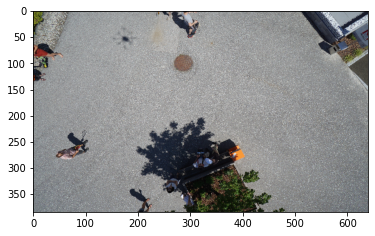

In [7]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

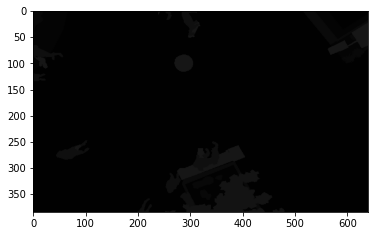

In [8]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [9]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)
print(xTrain_Test.shape)

(301, 384, 640, 3)


In [10]:
yTrain_Test = []

for seg in segments:  
  y = image.img_to_array(seg)
  yTrain_Test.append(y[:, :, 0])

yTrain_Test = np.array(yTrain_Test)
print(yTrain_Test.shape)

(301, 384, 640)


In [11]:
num_classes = len(np.unique(yTrain_Test[:, :, :]))

In [12]:
#Халява сработай
yTrain_Test_cat = keras.utils.to_categorical(yTrain_Test, num_classes)

In [13]:
#Сработала :)
print(yTrain_Test_cat.shape)

(301, 384, 640, 23)


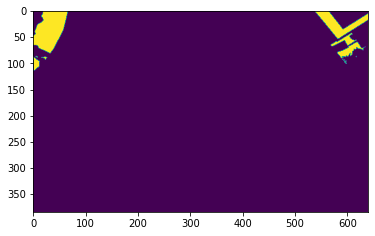

In [14]:
plt.imshow(yTrain_Test_cat[0,:,:,4])
plt.show()

In [15]:
N = 250
yTrain = yTrain_Test_cat[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test_cat[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [16]:
pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 160, 128)      0     

In [17]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers:
      layer.trainable = False
    x = pre_trained_model.layers[18].output
    block_5_out = pre_trained_model.layers[14].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_5_out)
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    
    # UP 0
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_5_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef, 'accuracy'])
    model.summary()
    return model

In [18]:
modelU = unet_pre_train(num_classes=num_classes, input_shape=xTest.shape[1:])

Tensor("block4_pool/MaxPool_1:0", shape=(None, 24, 40, 512), dtype=float32)
Tensor("block3_pool/MaxPool_1:0", shape=(None, 48, 80, 256), dtype=float32)
Tensor("block2_pool/MaxPool_1:0", shape=(None, 96, 160, 128), dtype=float32)
Tensor("block1_pool/MaxPool_1:0", shape=(None, 192, 320, 64), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 640, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 640, 64) 36928       block1_conv1[

In [19]:
%%time

callback = EarlyStopping(monitor='val_dice_coef', patience=10)
history = modelU.fit(xTrain, yTrain, epochs=50, batch_size=2, validation_data=(xTrain, yTrain), callbacks=[callback])

Epoch 1/50
125/125 [==============================] - 144s 1s/step - loss: 1.5555 - dice_coef: 0.4118 - accuracy: 0.5515 - val_loss: 2.8642 - val_dice_coef: 0.1641 - val_accuracy: 0.2275
Epoch 2/50
125/125 [==============================] - 143s 1s/step - loss: 1.3419 - dice_coef: 0.4617 - accuracy: 0.5973 - val_loss: 1.5657 - val_dice_coef: 0.4315 - val_accuracy: 0.5331
Epoch 3/50
125/125 [==============================] - 143s 1s/step - loss: 1.2231 - dice_coef: 0.4969 - accuracy: 0.6235 - val_loss: 2.2138 - val_dice_coef: 0.3192 - val_accuracy: 0.4030
Epoch 4/50
125/125 [==============================] - 143s 1s/step - loss: 1.1770 - dice_coef: 0.5159 - accuracy: 0.6471 - val_loss: 1.2158 - val_dice_coef: 0.4721 - val_accuracy: 0.6113
Epoch 5/50
125/125 [==============================] - 144s 1s/step - loss: 1.0892 - dice_coef: 0.5444 - accuracy: 0.6606 - val_loss: 1.2444 - val_dice_coef: 0.4982 - val_accuracy: 0.6099
Epoch 6/50
125/125 [==============================] - 143s 1s/ste

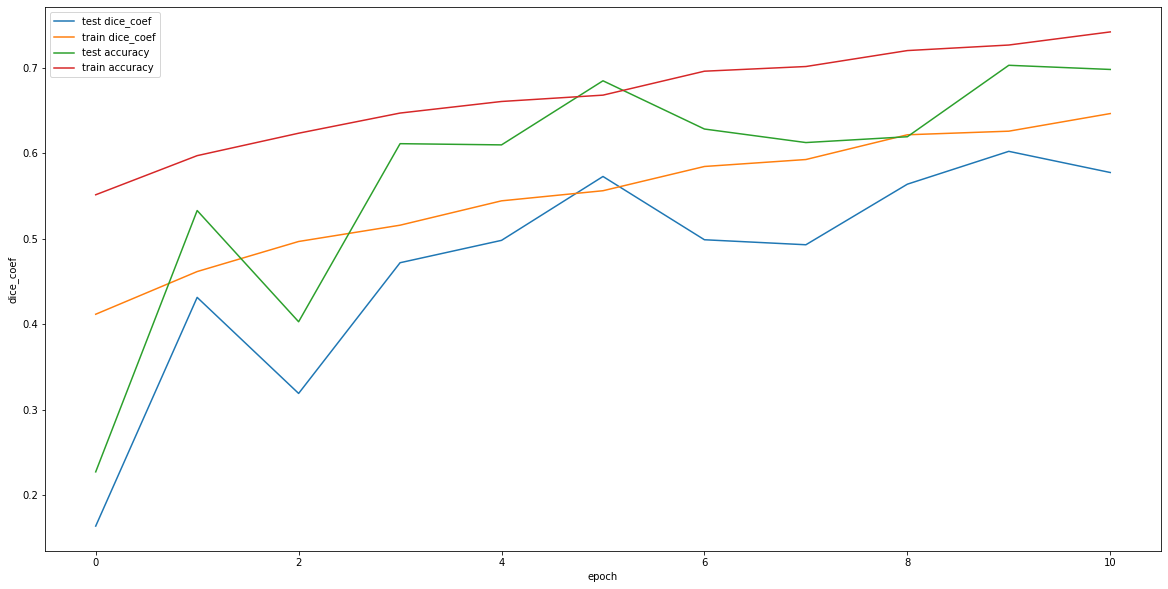

In [20]:
plt.figure(figsize =(20,10))
plt.plot(history.history['val_dice_coef'],label = 'test dice_coef')
plt.plot(history.history['dice_coef'],label='train dice_coef')
plt.plot(history.history['val_accuracy'],label = 'test accuracy')
plt.plot(history.history['accuracy'],label='train accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [ ]:
predu = modelU.predict(xTest)
print(predu.shape)

In [ ]:
n = 0
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

*Сделайте свою реализацию U-Net на TensorFlow

In [ ]:

img_input = Input(xTest.shape[1:])

# Block 1
x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
# запомним тензор для переноса
block_1_out = Activation('relu')(x)

x = MaxPooling2D()(block_1_out)

# Block 2
x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
# запомним тензор для переноса
block_2_out = Activation('relu')(x)

x = MaxPooling2D()(block_2_out)

# Block 3
x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
# запомним тензор для переноса
block_3_out = Activation('relu')(x)

x = MaxPooling2D()(block_3_out)

# Block 4
x = Conv2D(128, (3, 3), padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)
# запомним тензор для переноса
block_4_out = Activation('relu')(x)

x = MaxPooling2D()(block_4_out)

# Block 5
x = Conv2D(128, (3, 3), padding='same', name='block5_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block5_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block5_conv3')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)



# UP 1
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_4_out])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP 2
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# добавили перенос из понижаюшего плеча
x = concatenate([x, block_3_out])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP 3
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# добавили перенос из понижаюшего плеча
x = concatenate([x, block_2_out])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP 4
x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# добавили перенос из понижаюшего плеча
x = concatenate([x, block_1_out])
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# слой классификатор
x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

model = Model(img_input, x)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef, 'accuracy'])
model.summary()



In [ ]:
%%time

callback = EarlyStopping(monitor='val_dice_coef', patience=10)
history = model.fit(xTrain, yTrain, epochs=50, batch_size=2, validation_data=(xTrain, yTrain), callbacks=[callback])

In [ ]:
plt.figure(figsize =(20,10))
plt.plot(history.history['val_dice_coef'],label = 'test dice_coef')
plt.plot(history.history['dice_coef'],label='train dice_coef')
plt.plot(history.history['val_accuracy'],label = 'test accuracy')
plt.plot(history.history['accuracy'],label='train accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [ ]:
pred = model.predict(xTest)
print(pred.shape)

In [ ]:
n = 0
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()